# Plot Paloma data

## Imports and setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x // 1000))


wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yw580 (pico-lm). Use `wandb login --relogin` to force relogin


True

## Get data from runs

In [2]:
api = wandb.Api()

RUN_SCALE = "tiny"

runs = [
    api.run("pico-lm/pico-decoder/lne20rc1"),  # pico decoder tiny
    api.run("pico-lm/pico-relora/6vhmv4aj"),  # pico relora tiny
    api.run("pico-lm/pico-decoder/kzcalg17"),  # small
    api.run("pico-lm/pico-relora/5urfvs2j"),
]

dfs = []

for ridx, run in enumerate(runs):
    df = pd.DataFrame(run.scan_history())
    df["Model"] = rf"\texttt{{pico-{'decoder' if ridx % 2 == 0 else 'relora'}}}"
    df["Scale"] = "tiny" if ridx < 2 else "small"
    dfs.append(df)

run_data = pd.concat(dfs, ignore_index=True)

In [3]:
MAX_TIME = pd.Timedelta("800h")
MAX_TIME_HRS = MAX_TIME.total_seconds() / 3600
INTERVAL = pd.Timedelta("20h")

In [4]:
runtime_data = run_data.copy()

runtime_data["n_gpus"] = runtime_data.apply(lambda row: 16 if "decoder" in row["Model"] else 4, axis=1)
runtime_data["_runtime"] = pd.to_timedelta(runtime_data["_runtime"], unit="s")
runtime_data["_runtime"] = runtime_data["_runtime"] - runtime_data["_runtime"].iloc[0]
runtime_data["gpu_time"] = (runtime_data["_runtime"].dt.total_seconds() / 3600) * runtime_data["n_gpus"]


runtime_data.rename(columns={"eval/paloma": "PPL", "train/loss": "Loss"}, inplace=True)

runtime_data = runtime_data[runtime_data["gpu_time"] <= MAX_TIME_HRS]

In [14]:
def plot_metric(metric: str):
    colors = ["#1E88E5", "#FF992F"]
    models = sorted(runtime_data["Model"].unique().tolist())
    palette = dict(zip(models, colors))

    font_scale = 1.9

    sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})

    g = sns.FacetGrid(
        data=runtime_data,
        col="Scale",
        # row="Metric",
        height=6,
        aspect=1.5,
        sharey=True,
        sharex=True,
        margin_titles=False,
    )

    g.map_dataframe(sns.lineplot, x="gpu_time", y=metric, hue="Model", palette=palette)

    g.set_titles(row_template=r"Scale = \texttt{{{row_val}}}")

    for axid, ax in enumerate(g.axes.flat):
        if metric == "PPL":
            ax.set_ylim(0, 2000)
        else:
            ax.set_ylim(3, 11.5)
        if axid == 1:
            ax.legend(bbox_to_anchor=(1, 1), loc="upper right")

    g.set_axis_labels("GPU Hours", metric)

    plt.savefig(f"../graphs/training-{metric.lower()}-gpu.pdf")
    plt.show()

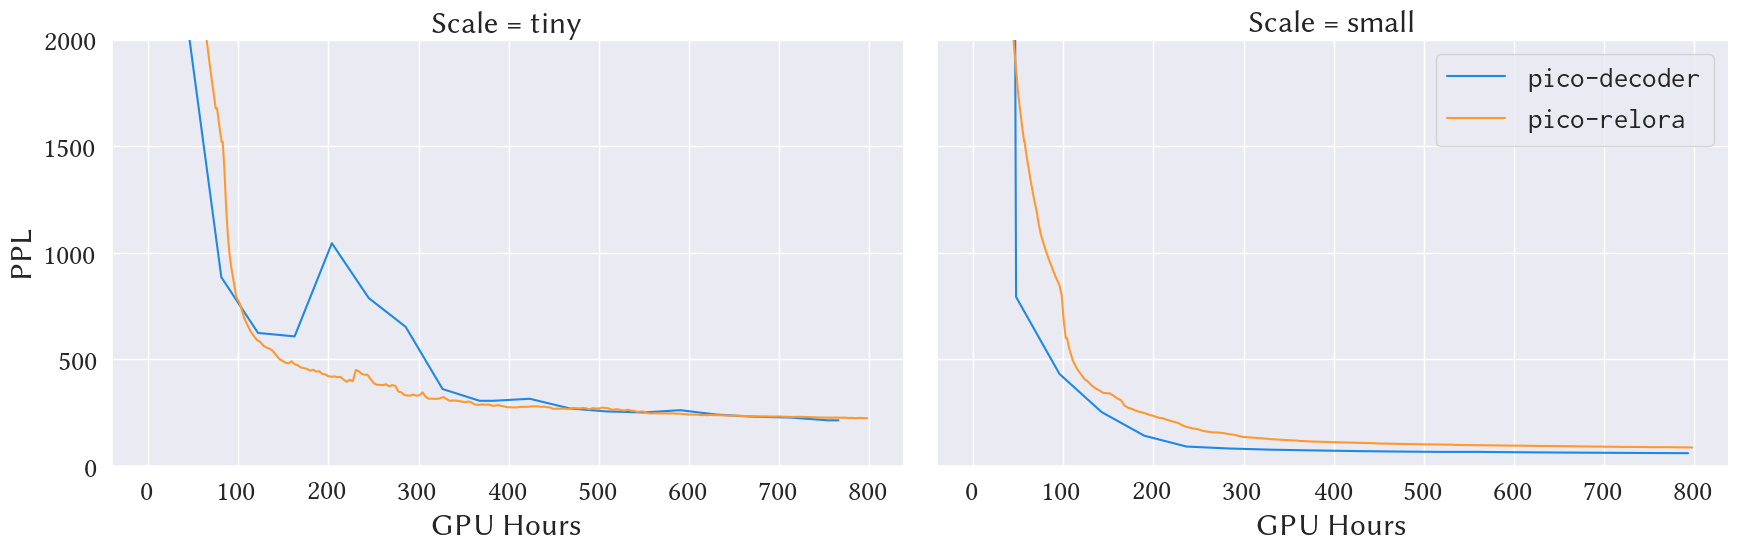

In [6]:
plot_metric("PPL")

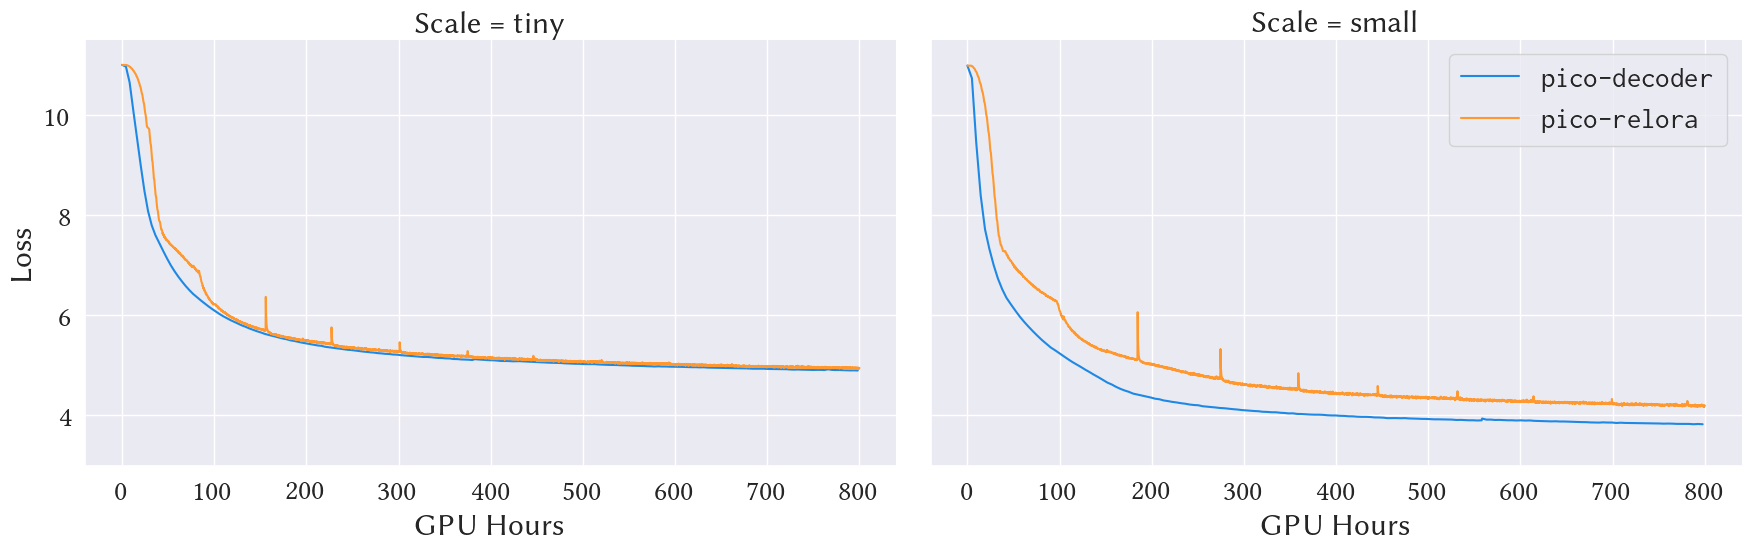

In [15]:
plot_metric("Loss")